# Conv-LSTM demand only

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Load taxi data
df = pd.read_parquet(r"C:\Users\justu\OneDrive\Desktop\Thesis\2009 taxi data\4. Taxi Data Square Grids and Weather\final.parquet")
df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])
df = df[['Trip_Pickup_DateTime', 'grid_cell_id', 'demand']]
df['grid_cell_id'] = df['grid_cell_id'].astype('int32')
df['demand'] = df['demand'].astype('float32')

In [3]:
# Map grid_cell_id to 2D grid coordinates
num_cols = 16  # Known number of columns in the grid
max_grid_id = df['grid_cell_id'].max()
num_rows = (max_grid_id // num_cols) + 1  # Calculate number of rows dynamically

df['grid_row'] = df['grid_cell_id'] // num_cols
df['grid_col'] = df['grid_cell_id'] % num_cols

In [4]:
# Create a time-indexed DataFrame
time_index = df['Trip_Pickup_DateTime'].sort_values().unique()
tensor = np.zeros((len(time_index), num_rows, num_cols), dtype=np.float32)

# Populate the tensor with demand values
for t, timestamp in enumerate(time_index):
    snapshot = df[df['Trip_Pickup_DateTime'] == timestamp]
    for _, row in snapshot.iterrows():
        row_idx = int(row['grid_row'])
        col_idx = int(row['grid_col'])
        if row_idx < num_rows and col_idx < num_cols:  # Ensure indices are within bounds
            tensor[t, row_idx, col_idx] = row['demand']

In [5]:
# Normalize the demand data to [0, 1]
scaler = MinMaxScaler()
tensor_flat = tensor.reshape(-1, 1)
tensor_normalized = scaler.fit_transform(tensor_flat).reshape(tensor.shape)

In [8]:
# Split into train (70%), validation (15%), test (15%)
train_cutoff = int(0.7 * len(time_index))
val_cutoff = int(0.85 * len(time_index))

X_train = tensor_normalized[:train_cutoff]
X_val = tensor_normalized[train_cutoff:val_cutoff]
X_test = tensor_normalized[val_cutoff:]

# Prepare sequences with look-back window Kd
Kd = 8  # Look-back window size

def create_sequences(data, Kd):
    X, y = [], []
    for t in range(Kd, len(data)):
        X.append(data[t-Kd:t])  # Historical demand
        y.append(data[t])      # Future demand
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, Kd)
X_val, y_val = create_sequences(X_val, Kd)
X_test, y_test = create_sequences(X_test, Kd)

# Add channel dimension for ConvLSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]
y_test = y_test[..., np.newaxis]

In [9]:
# Build the Conv-LSTM model
model = Sequential([
    ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(Kd, num_rows, num_cols, 1),
        padding='same',
        return_sequences=False
    ),
    Conv2D(
        filters=1,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    )
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 28, 16, 64)        150016    
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 16, 1)         577       
                                                                 
Total params: 150593 (588.25 KB)
Trainable params: 150593 (588.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Save the best model to this file
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the model with the best validation loss
    mode='min',               # Minimize the validation loss
    verbose=1
)

In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback]  
)

Epoch 1/100
192/192 [==============================] - ETA: 0s - loss: 4.2102e-04 - mae: 0.0051
Epoch 1: val_loss improved from inf to 0.00019, saving model to best_model.h5
192/192 [==============================] - 204s 1s/step - loss: 4.2102e-04 - mae: 0.0051 - val_loss: 1.9166e-04 - val_mae: 0.0034
Epoch 2/100


c:\Users\justu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - ETA: 0s - loss: 1.5189e-04 - mae: 0.0030
Epoch 2: val_loss improved from 0.00019 to 0.00014, saving model to best_model.h5
192/192 [==============================] - 211s 1s/step - loss: 1.5189e-04 - mae: 0.0030 - val_loss: 1.3876e-04 - val_mae: 0.0028
Epoch 3/100
192/192 [==============================] - ETA: 0s - loss: 1.1642e-04 - mae: 0.0027
Epoch 3: val_loss improved from 0.00014 to 0.00012, saving model to best_model.h5
192/192 [==============================] - 214s 1s/step - loss: 1.1642e-04 - mae: 0.0027 - val_loss: 1.2055e-04 - val_mae: 0.0026
Epoch 4/100
192/192 [==============================] - ETA: 0s - loss: 9.9026e-05 - mae: 0.0024
Epoch 4: val_loss improved from 0.00012 to 0.00011, saving model to best_model.h5
192/192 [==============================] - 213s 1s/step - loss: 9.9026e-05 - mae: 0.0024 - val_loss: 1.0926e-04 - val_mae: 0.0025
Epoch 5/100
192/192 [==============================] - ETA: 0s - loss: 8.7553e-05 - mae:

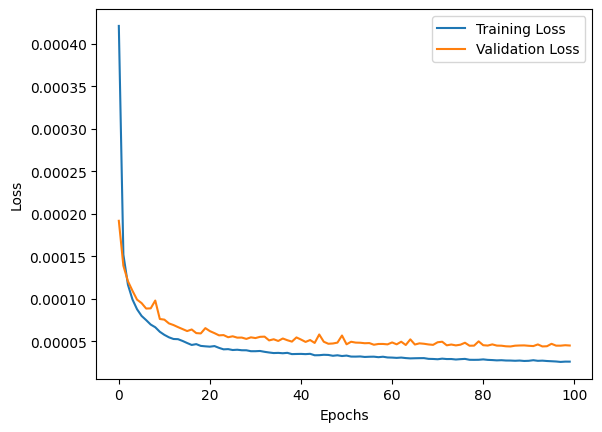

In [12]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save(r"C:\Users\justu\OneDrive\Desktop\Thesis\models\convlstm demand only\conv_lstm_model.h5")

c:\Users\justu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_model.h5")

In [15]:
# Evaluate the best model
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

41/41 [==============================] - 7s 167ms/step - loss: 4.2286e-05 - mae: 0.0015
Test Loss: 4.228570105624385e-05
Test MAE: 0.0014655700651928782


In [16]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
'''
# Optionally, reverse the normalization
y_pred_denormalized = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
'''

41/41 [==============================] - 7s 169ms/step


'\n# Optionally, reverse the normalization\ny_pred_denormalized = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)\ny_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)\n'

In [17]:
# Flatten the predictions and test data to 2D (required by MinMaxScaler)
y_pred_flat = y_pred.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)

# Denormalize using the scaler
y_pred_denormalized = scaler.inverse_transform(y_pred_flat).reshape(y_pred.shape)
y_test_denormalized = scaler.inverse_transform(y_test_flat).reshape(y_test.shape)

Aggregated Actual Demand (sample): [24160. 24730. 21018. 23722. 29501.]
Aggregated Predicted Demand (sample): [23646.852 23745.629 24219.768 23213.684 27426.453]


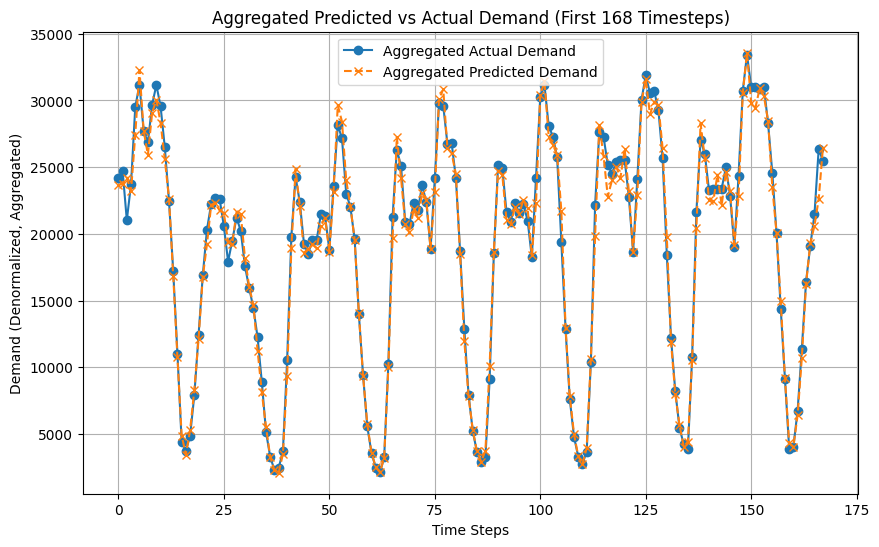

In [18]:
import matplotlib.pyplot as plt

# Select a specific time frame for comparison
time_steps = 168  # Number of time steps to visualize

# Aggregate demand across all grid cells for the first 168 timesteps
actual_demand_aggregated = np.sum(y_test_denormalized[:time_steps], axis=(1, 2, 3))
predicted_demand_aggregated = np.sum(y_pred_denormalized[:time_steps], axis=(1, 2, 3))

# Ensure the values are properly updated
print("Aggregated Actual Demand (sample):", actual_demand_aggregated[:5])
print("Aggregated Predicted Demand (sample):", predicted_demand_aggregated[:5])

# Plot aggregated actual vs predicted demand
plt.figure(figsize=(10, 6))
plt.plot(actual_demand_aggregated, label="Aggregated Actual Demand", linestyle='-', marker='o')
plt.plot(predicted_demand_aggregated, label="Aggregated Predicted Demand", linestyle='--', marker='x')

plt.title("Aggregated Predicted vs Actual Demand (First 168 Timesteps)")
plt.xlabel("Time Steps")
plt.ylabel("Demand (Denormalized, Aggregated)")
plt.legend()
plt.grid()
plt.show()


In [19]:
import numpy as np

# Flatten the arrays to compute MAPE for all points
actual_flat = y_test_denormalized.flatten()
predicted_flat = y_pred_denormalized.flatten()

# Filter for demand values >= 10
mask = actual_flat >= 10
filtered_actual = actual_flat[mask]
filtered_predicted = predicted_flat[mask]

# Calculate MAPE
mape = np.mean(np.abs((filtered_actual - filtered_predicted) / filtered_actual)) * 100

print(f"MAPE for demand values >= 10: {mape:.2f}%")

MAPE for demand values >= 10: 21.85%


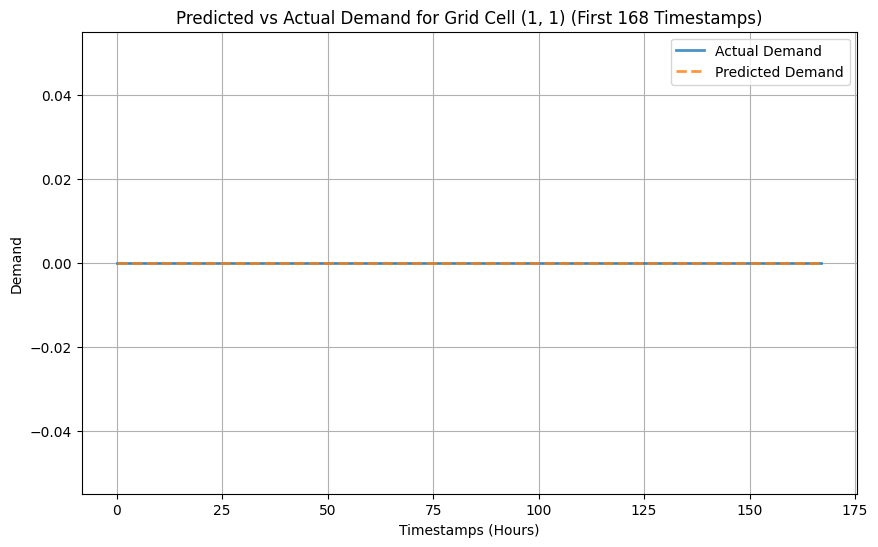

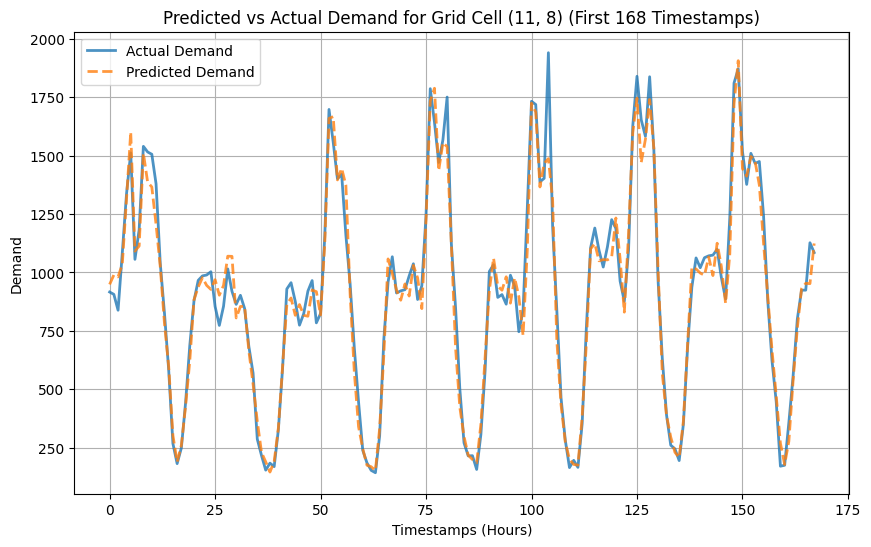

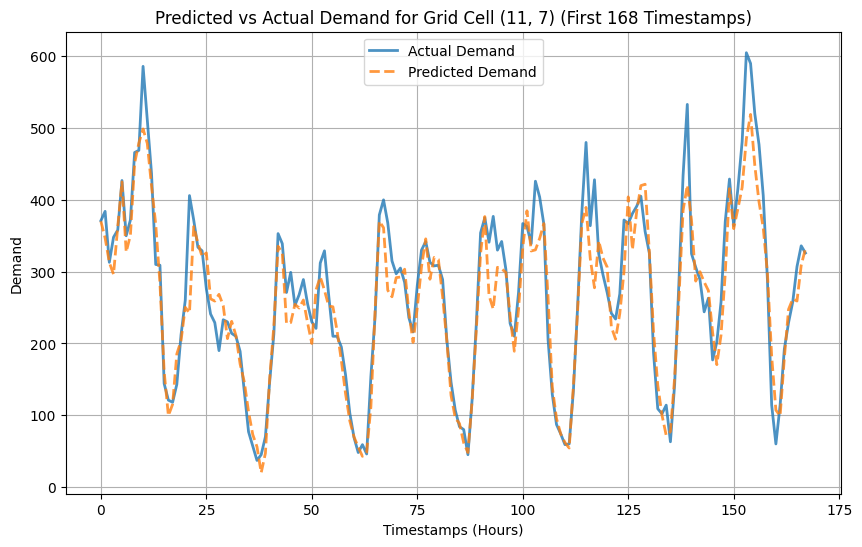

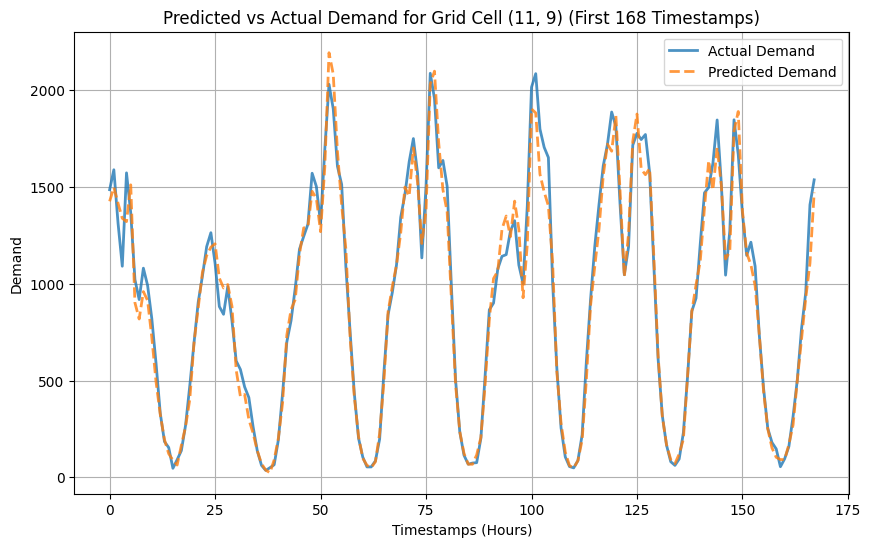

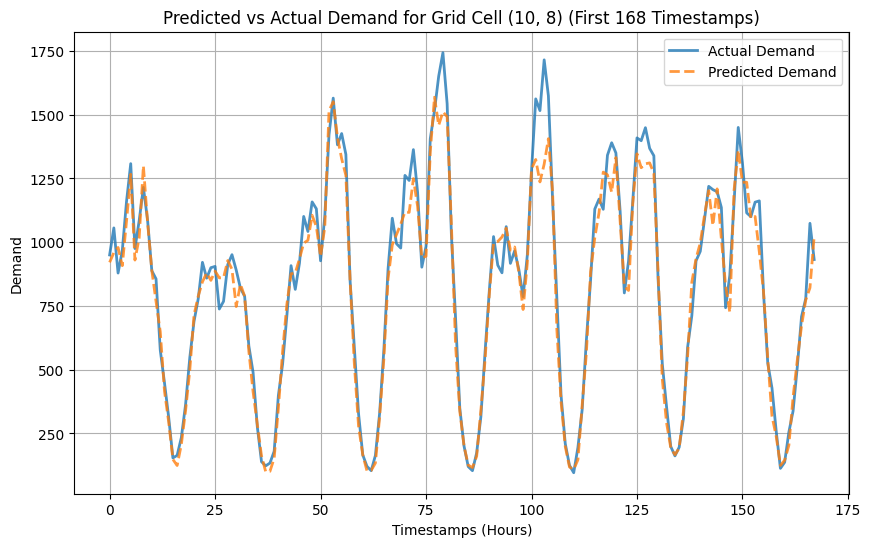

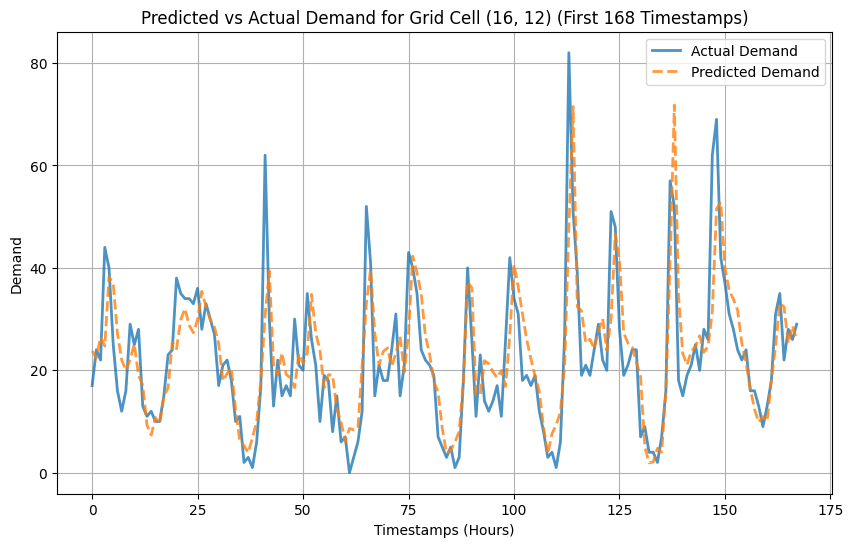

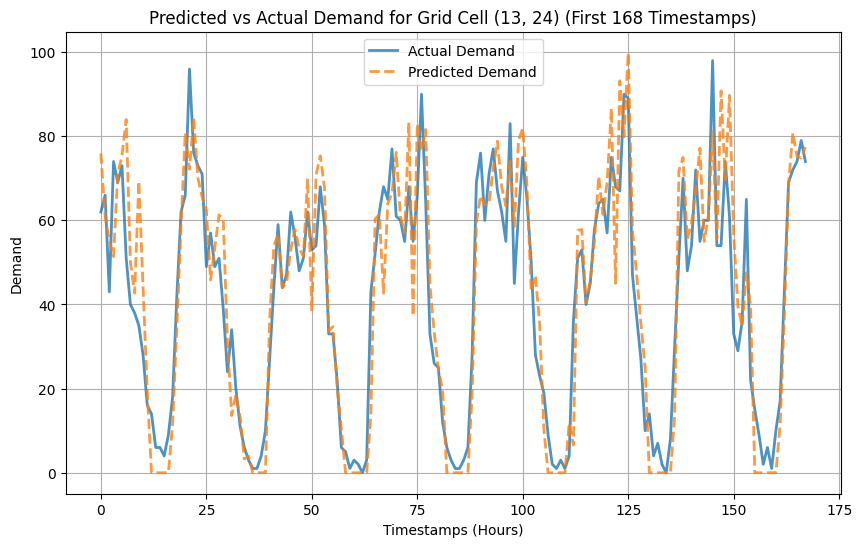

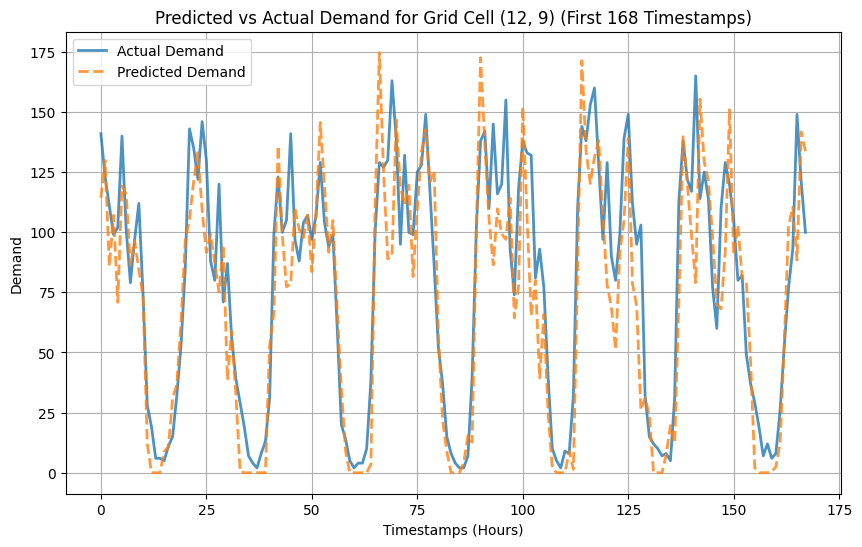

In [20]:
# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test_flat)
y_pred_original = scaler.inverse_transform(y_pred_flat)

# Define grid cells to analyze
grid_cells = [(1, 1), (11, 8), (11, 7), (11, 9), (10, 8), (16, 12), (13, 24), (12, 9)]  # List of (grid_row, grid_col)
timestamps_to_analyze = 168  # First 168 timestamps

# Loop through each grid cell
for grid_row, grid_col in grid_cells:
    # Calculate the corresponding grid cell index based on grid dimensions
    grid_cell = grid_row * num_cols + grid_col

    # Extract actuals and predictions for the grid cell
    if grid_cell >= y_test_original.shape[1]:
        print(f"Grid cell ({grid_row}, {grid_col}) is out of bounds. Skipping.")
        continue

    actuals = y_test_original[:timestamps_to_analyze, grid_cell]
    preds = y_pred_original[:timestamps_to_analyze, grid_cell]

    # Plot predicted vs actual for this grid cell
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Demand", alpha=0.8, linewidth=2)
    plt.plot(preds, label="Predicted Demand", alpha=0.8, linestyle="dashed", linewidth=2)
    plt.title(f"Predicted vs Actual Demand for Grid Cell ({grid_row}, {grid_col}) (First 168 Timestamps)")
    plt.xlabel("Timestamps (Hours)")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid()
    plt.show()

    demand_group       MAPE
0    Weakest 25%  99.762693
1        25%-50%  81.455351
2        50%-75%  31.544034
3  Strongest 25%  13.347331


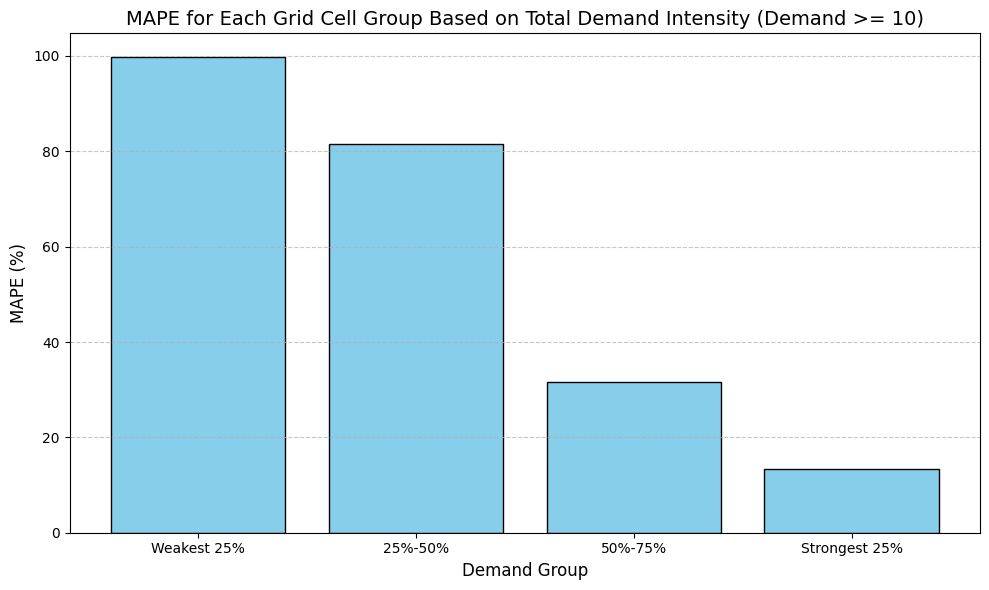

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test_flat)
y_pred_original = scaler.inverse_transform(y_pred_flat)

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Create a DataFrame to hold grid cell data
grid_data = pd.DataFrame({
    "grid_cell_id": range(num_rows * num_cols),  # Update for num_rows and num_cols
    "total_demand": total_demand
})

# Exclude cells with zero total demand
grid_data = grid_data[grid_data["total_demand"] > 0]

# Divide remaining cells into 4 groups based on total demand (quartiles)
grid_data["demand_group"] = pd.qcut(
    grid_data["total_demand"], 
    4, 
    labels=["Weakest 25%", "25%-50%", "50%-75%", "Strongest 25%"]
)

# Update the MAPE calculation function to include only demand values >= 10
def compute_mape(actual, predicted):
    # Filter for actual demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

# Compute MAPE for each grid cell
mape_values = []
for grid_cell in grid_data["grid_cell_id"]:
    actuals = y_test_original[:, grid_cell]
    preds = y_pred_original[:, grid_cell]
    mape = compute_mape(actuals, preds)
    mape_values.append(mape)

# Add MAPE values to grid_data
grid_data["MAPE"] = mape_values

# Drop NaN MAPE values (if any grid cells had no valid data)
grid_data = grid_data.dropna(subset=["MAPE"])

# Calculate average MAPE for each group
grouped_mape = grid_data.groupby("demand_group")["MAPE"].mean().reset_index()

# Display the results
print(grouped_mape)

# Plot the MAPE for each group
plt.figure(figsize=(10, 6))
plt.bar(grouped_mape["demand_group"], grouped_mape["MAPE"], color="skyblue", edgecolor="black")
plt.title("MAPE for Each Grid Cell Group Based on Total Demand Intensity (Demand >= 10)", fontsize=14)
plt.xlabel("Demand Group", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

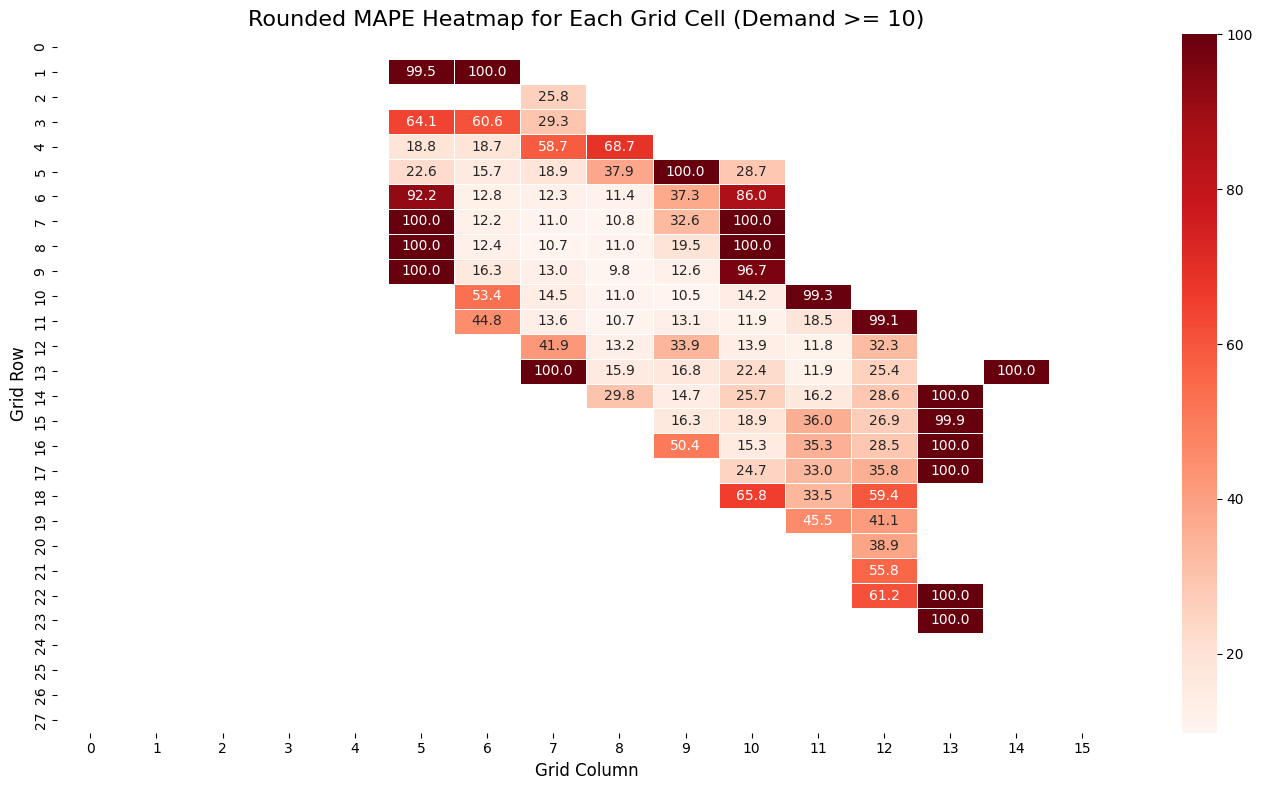

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test_flat)
y_pred_original = scaler.inverse_transform(y_pred_flat)

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Filter out grid cells with zero total demand
valid_cells = total_demand > 0

# Compute MAPE for each valid grid cell
def compute_mape(actual, predicted):
    # Filter for demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

mape_values = []
for grid_cell in range(num_rows * num_cols):
    if valid_cells[grid_cell]:
        actuals = y_test_original[:, grid_cell]
        preds = y_pred_original[:, grid_cell]
        mape = compute_mape(actuals, preds)
        mape_values.append(mape)
    else:
        mape_values.append(np.nan)  # Assign NaN for invalid cells

# Reshape MAPE values into a 2D grid
mape_grid = np.array(mape_values).reshape(num_rows, num_cols)

# Round MAPE values for better visualization
mape_grid_rounded = np.round(mape_grid, 1)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(mape_grid_rounded, annot=True, fmt=".1f", cmap="Reds", cbar=True, linewidths=0.5)
plt.title("Rounded MAPE Heatmap for Each Grid Cell (Demand >= 10)", fontsize=16)
plt.xlabel("Grid Column", fontsize=12)
plt.ylabel("Grid Row", fontsize=12)
plt.tight_layout()
plt.show()